# Drift Correction

In normal operation, the PTP slave continuously adjusts the increment value of its RTC, such that it compensates the time offset drift due to the frequency offset. In contrast, when we collect timestamps from the testbed, increment adjustment is disabled, as it otherwise would disturb the scheme that we use in order to collect the ground truth of timestamps. Hence, the drift correction step must be carried out in our offline processing.

It is even advantageous to handle the drift correction offline. The difference is that the real-time tuning of the increment relies on fixed-point arithmetic, and in our hardware the fixed-point representation is not very good (due to a limitation of the Xilinx IP that we use). In contrast, the offline processing estimates and corrects drift/frequency using double-precision floating-point numbers, so that resolution is not a problem. This should improve performance substantially. And this is still a practical approach, as it reflects the performance achieved by a well designed RTC hardware.

## Dataset Loading

In [1]:
import sys, os, pprint, time
sys.path.append(os.path.abspath('../'))
import argparse, logging, sys
import ptp.reader
import ptp.ls
import ptp.metrics
import ptp.frequency
import ptp.pktselection
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import logging
logging.basicConfig(level=logging.WARNING)
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#filename = "serial-20200114-102612.json" # ocxo, 2 RRUs, no FH traffic
filename = "serial-20200116-215655.json" # ocxo, 2 RRUs, FH traffic, nighttime
#filename = "serial-20200117-081236.json" # xo, 2 RRUs, FH traffic, daytime

reader = ptp.reader.Reader("../data/" + filename)
reader.run()
print("Dataset info:")
pprint.pprint(reader.metadata)

Dataset info:
{'fh_traffic': {'bitrate': {'dl': 837120000.0, 'ul': 837120000.0},
                'fs': 7680000.0,
                'iq_size': 24,
                'n_rru_dl': 2,
                'n_rru_ul': 2,
                'n_spf': 64,
                'type': 'inline'},
 'hops': 4,
 'n_rru_ptp': 2,
 'oscillator': 'ocxo',
 'start_time': '2020-01-16 21:56:55',
 'sync_period': 0.25}


In [3]:
### Dataset gaps and PTP interval

Checking sequenceIDs: OK (no gaps)


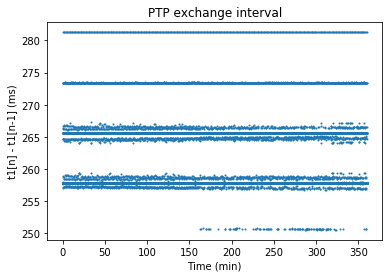

In [4]:
# PTP analyser
analyser = ptp.metrics.Analyser(reader.data)
analyser.check_seq_id_gaps()
analyser.plot_ptp_exchange_interval_vs_time(save=False)

### Frequency offset estimation

For initial inspection, estimate frequency offset using LS and the unbiased (raw) frequency offset estimator.

#### Unbiased estimator:

In [5]:
freq_delta = 64

# Raw frequency estimations (differentiation of raw time offset measurements)
freq_estimator = ptp.frequency.Estimator(reader.data, delta=freq_delta)
freq_estimator.set_truth(delta=64)
freq_estimator.optimize_to_y()
freq_estimator.process()

print("Observation window for freq. offset estimation: %d" %freq_estimator.delta)

Observation window for freq. offset estimation: 8192


#### LS:

In [6]:
N_ls       = 4096
T_ns       = 1e9/4

# Least-squares estimator
ls = ptp.ls.Ls(N_ls, reader.data, T_ns)
ls.process("eff")

### Frequency Offset Analysis


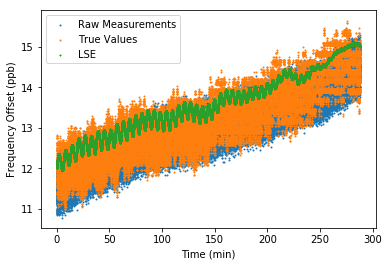

In [7]:
analyser.plot_foffset_vs_time(save=False)

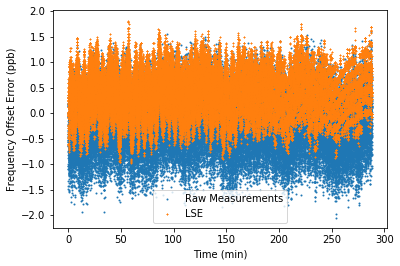

In [8]:
analyser.plot_foffset_err_vs_time(save=False)

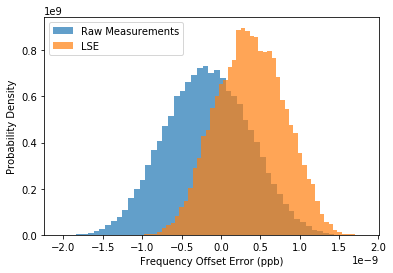

In [9]:
analyser.plot_foffset_err_hist(save=False)

In [10]:
analyser.foffset_err_stats()


Frequency offset estimation error statistics:

y_est                 Mean:   -0.174 ppb  Sdev:    0.526 ppb  RMS:     0.554 ppb
y_ls_eff              Mean:    0.365 ppb  Sdev:    0.427 ppb  RMS:     0.561 ppb


#### Comments 

There are two important comments regarding these plots. The first concerns LS performance. The second concerns the "true" frequency measurements.

Note that frequency offset estimations provided by LS tend to be biased and its variance is similar to the variance of regular frequency offset measurements. Hence, it seems better to simply use the regular measurements.

Regarding "true" frequency measurements, note that they are also window-based. If the "true" time offset measurements were noiseless, the window size could be 2, which would then lead to nearly instantaneous measurements of the frequency offset. However, unfortunately the "true" time offset measurements are noisy due to PPS uncertainty. For example, they could easily oscillate +-4 ns around the true value. Due to the range of drifts (very few nanoseconds per timestamp interval), this noise/uncertainty affects frequency offset measurements substantially. This serves as the motivation for computing the "true" frequency offset using longer windows, which amortizes the uncertainty.

Suppose PPS sync has an uncertainty of 20 ns. If the observation window for true frequency offset values corresponds to 64 PTP exchanges at a rate of 4 exchanges/sec, the observation window is in fact of 16 secs. This way, 20 ns amounts to `20 ns/16 sec` which is slightly more than 1 ppb of noise. The problem, however, is that while we can reduce the measurement noise by increasing the observation window, this comes with the drawback of losing notion of short-term variations in frequency. In the end, because of this, we shouldn't trust the frequency offset "truth". Since it is window based, we will never know the true value at a specific instant. 

Later on in this netbook, we will evaluate the different optimization strategies for drift estimation while considering the referred limitation of the window-based truth computation.

### Delay PDF and Delay Asymmetry

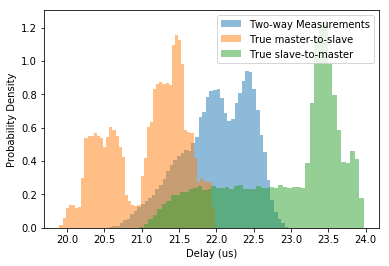

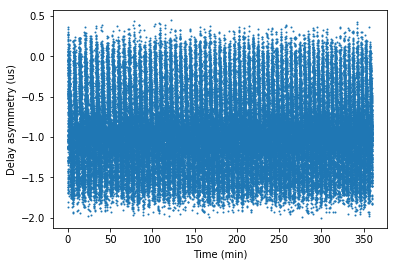

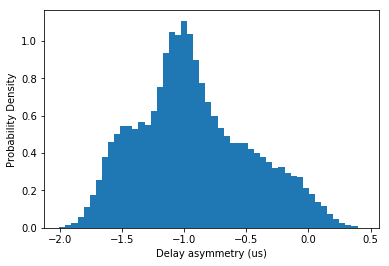

In [11]:
analyser.plot_delay_hist(save=False)
analyser.plot_delay_asym_vs_time(save=False)
analyser.plot_delay_asym_hist(save=False)

### Drift per exchange and Cumulative drift

Function `freq_estimator.estimate_drift()` computes the incremental drifts experienced by each PTP exchange based on the frequency offset measurements that were computed by `freq_estimator.process()`.

For comparison, the "true drift" (i.e. `x[n] - x[n-1]`) is computed and plotted next. Note, however, that the true drift suffers from uncertainty of the PPS synchronization, so the comparison is not very accurate when observed per iteration (i.e. when comparing the $n$-th iteration to iteration $n-1$).

Due to the uncertainty of the truth within consecutive samples, it is also interesting to observe the cumulative drift. The first cumulative sample is `x[1] - x[0]`, the second is `(x[2] - x[1]) + (x[1] - x[0])`, which is equal to `x[2] - x[0]` and so on, such that it generalizes to `cum_x[n] = x[n] - x[0]`. The cumulative metric is useful because, as `n` grows, the true time offset drift also grows, and so the uncertainties of `x[n]` and `x[0]` eventually become negligible in the computation. 

In the longer term, if the drift estimations are good, the cumulative sum of drift estimates should stay sufficiently close to the "true" cumulative drift.

Next, we evaluate three different drift estimation strategies and their performance with respect to both the "true" drift and "true" cumulative drift. For each strategy, there is an optimizer, which finds the configuration (e.g. window length) that leads to the best performance.

### Drift Optimizer #1

The first drift estimation optimizer first optimizes the window length of window-based frequency offset estimations, then computes the drift for each iteration based on the frequency offset estimates. The optimization is done to minimize the MSE between the frequency offsest estimates and the "true" frequency offset values. This is not expected to be the best, due to the aforementioned issue of "true" frequency offset computations being innacurate  due to window-based computation. Also, this strategy does not optimize the metric that is really of interest, i.e. the time offset drift. 

Optimize window w.r.t to "true" y
Process with delta 16384

Time offset drift estimation error statistics:

Drift                 Mean:   -0.090 ns  Sdev:    4.848 ns  RMS:     4.849 ns
Cumulative Drift      Mean: -3087.963 ns  Sdev:  1584.756 ns  RMS:   3470.874 ns


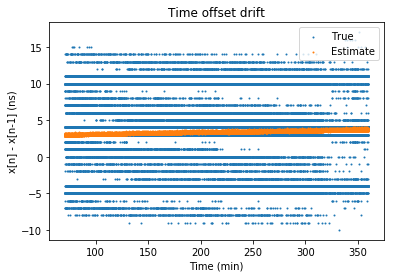

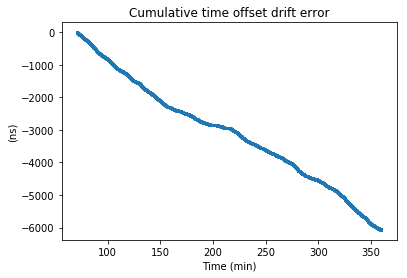

In [12]:
print("Optimize window w.r.t to \"true\" y")
freq_estimator.set_truth(delta=64)
freq_estimator.optimize_to_y() # optimize w.r.t. the truth
print("Process with delta {:d}".format(freq_estimator.delta))
freq_estimator.process()
freq_estimator.estimate_drift()
analyser.toffset_drift_err_stats()
analyser.plot_toffset_drift_vs_time(save=False)

### Drift Optimizer #2

The second drift estimation optimizer instead optimizes the drift estimates directly, while still relying on window-based unbiased frequency offset measurements. For each frequency offset estimation vector, it computes the time offset drift estimates over time and assesses the match with respect to the true drift.

Optimize window w.r.t to true time offset drift
Process with delta 256

Time offset drift estimation error statistics:

Drift                 Mean:   -0.002 ns  Sdev:    5.595 ns  RMS:     5.595 ns
Cumulative Drift      Mean:  -43.201 ns  Sdev:   58.676 ns  RMS:    72.864 ns


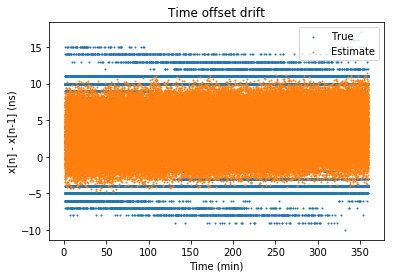

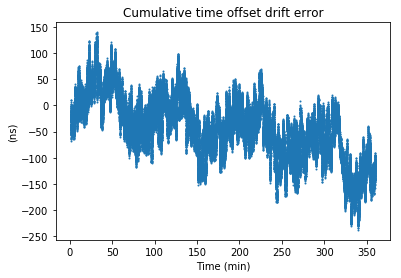

In [13]:
print("Optimize window w.r.t to true time offset drift")
freq_estimator.optimize_to_drift() # optimize w.r.t. the drift
print("Process with delta {:d}".format(freq_estimator.delta))
freq_estimator.process()
freq_estimator.estimate_drift()
analyser.toffset_drift_err_stats()
analyser.plot_toffset_drift_vs_time(save=False)

### Drift Estimator/Optimizer #3

The third approach is completely different. Instead of estimating frequency offset with the window-based approach, and then computing drift estimates, this approach relies on a PI loop that outputs drift estimates directly. The PI loop receives in its input the raw two-way time offset estimates and attempts to predict the time offset drift such that it minimizes the error between the prediction of the next time offset and the input time offset estimate. The filtered error of the PI loop is then used directly as the time offset drift estimate.

PI loop


Optimal damping factor: 0.707000
Optimal loop bandwidth: 0.000200

Time offset drift estimation error statistics:

Drift                 Mean:    0.001 ns  Sdev:    4.839 ns  RMS:     4.839 ns
Cumulative Drift      Mean:   -9.602 ns  Sdev:   53.034 ns  RMS:    53.897 ns


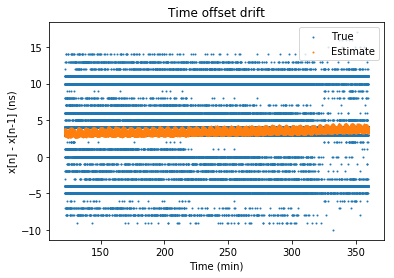

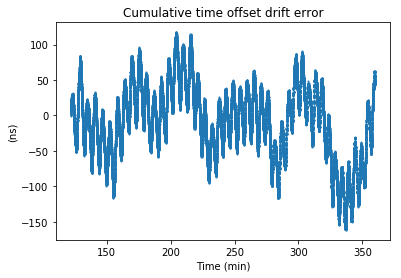

In [14]:
print("PI loop")
damping, loopbw = freq_estimator.optimize_loop()

print("Optimal damping factor: {:f}".format(damping))
print("Optimal loop bandwidth: {:f}".format(loopbw))
        
freq_estimator.loop(damping = damping, loopbw = loopbw)
analyser.toffset_drift_err_stats()
analyser.plot_toffset_drift_vs_time(save=False)

### Using drift compensation on packet selection

Drift compensation is used to remove the "quasi-deterministic" variation of the time offset prior to applying packet selection operators.

In [15]:
def run_all(drift_comp, N):
    """Run all packet selection algorithms with the same window length
        
    Args:
        drift_comp :  Whether to use drift compensation
        N          :  Window length
    """
    # Sample-average
    pkts = ptp.pktselection.PktSelection(N, reader.data)
    pkts.process("avg-normal", drift_comp=drift_comp)

    # Exponentially weighted moving average
    pkts.process("ewma", drift_comp=drift_comp)

    # Sample-median
    pkts.process("median", drift_comp=drift_comp)

    # Sample-minimum
    pkts.process("min", drift_comp=drift_comp)

    # Sample-mode
    pkts.process("mode", drift_comp=drift_comp)

    # Sample-maximum
    pkts.process("max", drift_comp=drift_comp)

### Scenario #1: no drift compensation


Time offset estimation error statistics:

x_est                 Mean: -923.851 ns  Sdev:  455.767 ns  RMS:   1030.158 ns
x_pkts_avg_normal     Mean: -1140.579 ns  Sdev:  269.153 ns  RMS:   1171.906 ns
x_pkts_ewma           Mean: -1357.707 ns  Sdev:  230.340 ns  RMS:   1377.108 ns
x_pkts_median         Mean: -1087.801 ns  Sdev:  318.617 ns  RMS:   1133.502 ns
x_pkts_min            Mean: -1031.937 ns  Sdev:  310.380 ns  RMS:   1077.604 ns
x_pkts_max            Mean: -1180.418 ns  Sdev:   97.982 ns  RMS:   1184.478 ns
x_pkts_mode           Mean: -1107.101 ns  Sdev:  428.464 ns  RMS:   1187.120 ns
x_ls_eff              Mean: -940.434 ns  Sdev:   72.717 ns  RMS:   943.241 ns


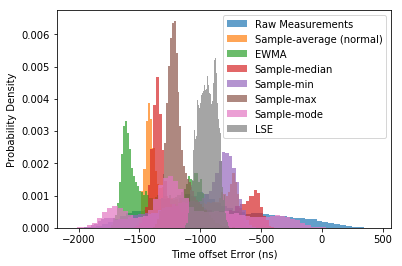

In [16]:
# Run all packet selection algorithms without drift compensation
N = 128
run_all(False, N)
analyser.toffset_err_stats()
analyser.plot_toffset_err_hist(save=False)

Without drift compensation, we do not expected the average error to be reliably close to a value corresponding to the delay asymmetry. This can be seen by comparing the "true" asymmetry values below to the the time offset error histogram (or the statistics) above.

In [17]:
analyser.delay_asymmetry()


Delay asymmetry analysis:

Metric 	      m-to-s	      s-to-m	   asymmetry
Average	 21078.66 ns	 22922.64 ns	  -921.99 ns
Minimum	 19896.00 ns	 20966.00 ns	  -535.00 ns
Maximum	 21987.00 ns	 23975.00 ns	  -994.00 ns
Median	 21212.00 ns	 23276.00 ns	 -1032.00 ns


-921.991160406286

For completeness, we can also inspect max|TE| vs time.

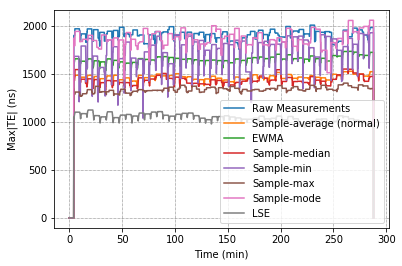

In [18]:
analyser.plot_max_te(save=False, window_len = 1000)

Furthermore, note that, without drift compensation, the window length has to be short. Otherwise, the time offset drift disturbs the selection strategy.

Observe for example what happens when the window is increased:


Time offset estimation error statistics:

x_est                 Mean: -923.851 ns  Sdev:  455.767 ns  RMS:   1030.158 ns
x_pkts_avg_normal     Mean: -2672.485 ns  Sdev:  122.996 ns  RMS:   2675.314 ns
x_pkts_ewma           Mean: -4411.263 ns  Sdev:  205.832 ns  RMS:   4416.063 ns
x_pkts_median         Mean: -2674.612 ns  Sdev:  287.162 ns  RMS:   2689.983 ns
x_pkts_min            Mean: -2524.977 ns  Sdev:  286.105 ns  RMS:   2541.135 ns
x_pkts_max            Mean: -2710.964 ns  Sdev:  135.935 ns  RMS:   2714.370 ns
x_pkts_mode           Mean: -2674.735 ns  Sdev:  690.303 ns  RMS:   2762.377 ns
x_ls_eff              Mean: -940.434 ns  Sdev:   72.717 ns  RMS:   943.241 ns


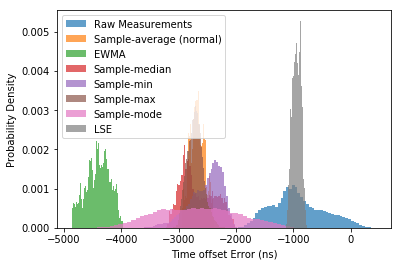

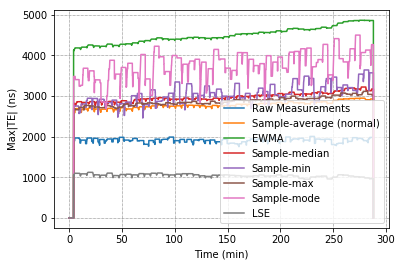

In [19]:
N = 1024
run_all(False, N)
analyser.toffset_err_stats()
analyser.plot_toffset_err_hist(save=False)
analyser.plot_max_te(save=False, window_len = 1000)

Note that performance was so much degraded that it became even worse than raw measurements.

### Scenario #2: enabled drift compensation

Next, let's introduce drift compensation prior to packet selection.

In [20]:
# Run all packet selection algorithms with drift compensation
N = 128
run_all(True, N)

In [21]:
analyser.toffset_err_stats()


Time offset estimation error statistics:

x_est                 Mean: -923.851 ns  Sdev:  455.767 ns  RMS:   1030.158 ns
x_pkts_avg_normal     Mean: -925.576 ns  Sdev:  276.697 ns  RMS:   966.050 ns
x_pkts_ewma           Mean: -924.461 ns  Sdev:  242.703 ns  RMS:   955.789 ns
x_pkts_median         Mean: -863.989 ns  Sdev:  320.953 ns  RMS:   921.676 ns
x_pkts_min            Mean: -795.347 ns  Sdev:  304.520 ns  RMS:   851.651 ns
x_pkts_max            Mean: -969.625 ns  Sdev:   71.776 ns  RMS:   972.278 ns
x_pkts_mode           Mean: -869.764 ns  Sdev:  422.635 ns  RMS:   967.011 ns
x_ls_eff              Mean: -940.434 ns  Sdev:   72.717 ns  RMS:   943.241 ns


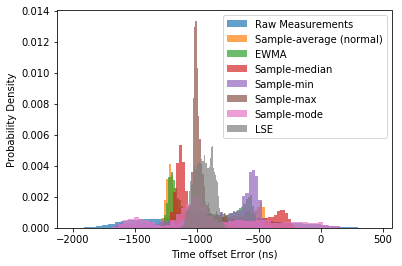

In [22]:
analyser.plot_toffset_err_hist(save=False)

Now, we can see a better match between the average error of the packet-selection estimates with respect to the "true" asymmetry figures of each metric. For instance, the average error of the sample-max above is now closer to the delay asymmetry of the true maximum delay.

This is the justification for leaving the drift compensation feature enabled by default.

In [23]:
analyser.delay_asymmetry()


Delay asymmetry analysis:

Metric 	      m-to-s	      s-to-m	   asymmetry
Average	 21078.66 ns	 22922.64 ns	  -921.99 ns
Minimum	 19896.00 ns	 20966.00 ns	  -535.00 ns
Maximum	 21987.00 ns	 23975.00 ns	  -994.00 ns
Median	 21212.00 ns	 23276.00 ns	 -1032.00 ns


-921.991160406286

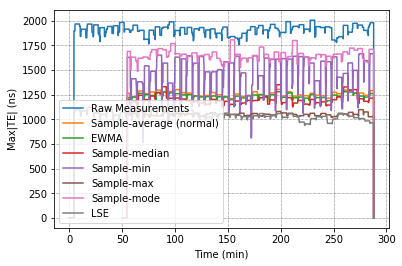

In [24]:
analyser.plot_max_te(save=False, window_len = 1000)

The above Max|TE| vs time plot highlights also that all packet selection methods are now outperforming the raw measurements when drift compensation is enabled. This is what we would expect. 

Note packet-selection results start only once there are drift estimates available (after the transitory of drift estimation).

Also, we expect to be able to improve performance (up to a certain point) by increasing the selection window length when drift compensation is enabled. This can be observed next:


Time offset estimation error statistics:

x_est                 Mean: -923.851 ns  Sdev:  455.767 ns  RMS:   1030.158 ns
x_pkts_avg_normal     Mean: -926.597 ns  Sdev:   80.129 ns  RMS:   930.056 ns
x_pkts_ewma           Mean: -925.441 ns  Sdev:   68.249 ns  RMS:   927.954 ns
x_pkts_median         Mean: -1013.187 ns  Sdev:   83.889 ns  RMS:   1016.653 ns
x_pkts_min            Mean: -547.335 ns  Sdev:   46.391 ns  RMS:   549.297 ns
x_pkts_max            Mean: -991.544 ns  Sdev:   41.088 ns  RMS:   992.394 ns
x_pkts_mode           Mean: -983.989 ns  Sdev:   56.601 ns  RMS:   985.616 ns
x_ls_eff              Mean: -940.434 ns  Sdev:   72.717 ns  RMS:   943.241 ns


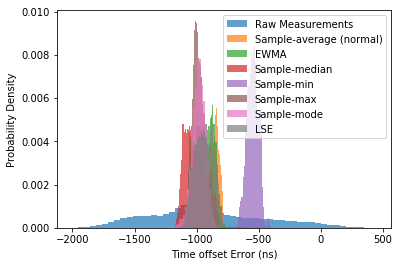

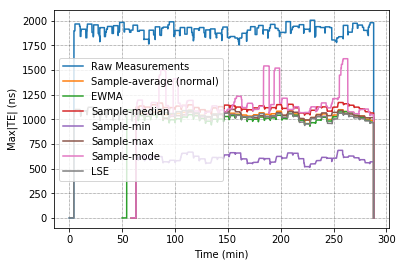

In [25]:
# Run all packet selection algorithms with drift compensation
N = 2048
run_all(True, N)
analyser.toffset_err_stats()
analyser.plot_toffset_err_hist(save=False)
analyser.plot_max_te(save=False, window_len = 1000)

We this larger window, we can see that performance improves and results now are even closer to the true asymmetry figures.